In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import os
import sys

# Add src to path
sys.path.append("src")
from sift import sift
from ransac import ransac
from stitch import stitch
from BWImage import BWImage

## Jupyter notebooks settings.

# Reload modules before executing each cell.
%load_ext autoreload
%autoreload 2 

# Print all print statements.
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" 

# Set white as color for pixels with no value.
BWImage.blank_value = 0

# Introduction

## Get homography matrices

$$
\begin{bmatrix}
x^2_i\\
y^2_i
\end{bmatrix}
 =
H_{2,1}
\begin{bmatrix}
x^1_i\\
y^1_i
\end{bmatrix}
$$

$$
\begin{bmatrix}
x^3_i\\
y^3_i
\end{bmatrix}
 =
H_{3,2}
\begin{bmatrix}
x^2_i\\
y^2_i
\end{bmatrix}
$$

$$
\begin{bmatrix}
x^2_i\\
y^2_i
\end{bmatrix}
 =
H_{2}
\begin{bmatrix}
x^1_i\\
y^1_i
\end{bmatrix}
$$

$$
\begin{bmatrix}
x^3_i\\
y^3_i
\end{bmatrix}
 =
H_{3}
\begin{bmatrix}
x^1_i\\
y^1_i
\end{bmatrix}
$$

In general,

$$
\begin{bmatrix}
x^j_i\\
y^j_i
\end{bmatrix}
=
H_j
\begin{bmatrix}
x^1_i\\
y^1_i
\end{bmatrix}
$$

where $H_j = H_{j, j-1} \times H_{j-2, j-1} \times \cdots \times H_{2, 1}$ and we take $H_1 = I$, the identity matrix.

To get the value of the points in canvas from the source images we do the following:
$$
\begin{bmatrix}
x^1_j\\
y^1_j\\
\end{bmatrix}
=
\begin{bmatrix}
x^c_j\\
y^c_j\\
\end{bmatrix}
-
\begin{bmatrix}
t_x\\
t_y
\end{bmatrix}
$$

Relationship between coordinates w.r.t any image img-i w.r.t to img1 is obtained from the homographies above.

In [2]:
img1 = cv.imread('data/input/img1.png')
img2 = cv.imread('data/input/img2.png')
img3 = cv.imread('data/input/img3.png')

imgs = [img1, img2, img3]
num_images = len(imgs)

## Get corresponding points and homographies.
# cpts -> Corresponding points.
cpts = []
# Homographies.
# H[i] = H_{i+2, i+1}. Homography to get img[i+1] from img[i].
# H[0] = H_{21}.
H = []
for i in range(num_images-1):
    cpts.append(sift(imgs[i+1], imgs[i]))
    H.append(ransac(cpts[i]))

# NOTE-1: Therefore, [xi, yi] = H[i] x H[i-1] x ... x [x1, y1].
# NOTE-2: Variable H is used in a different meaning in `stitch.py`.

[ WARN:0@0.365] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


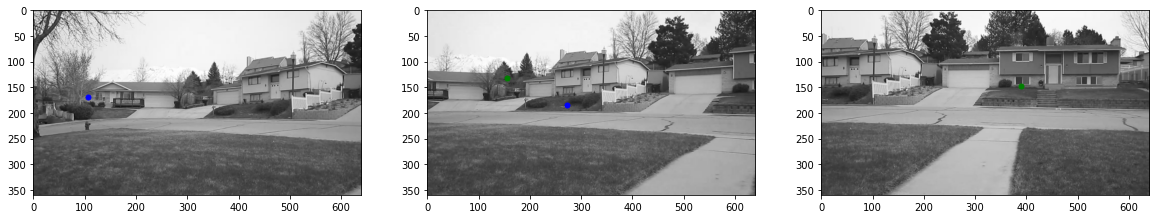

In [3]:
## View input images and a sample point correspondance.
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)
_l, _k = 20, 100
ax[0].plot(cpts[0][0][_l][1], cpts[0][0][_l][0], marker='o', markersize=5, c='b')
ax[1].plot(cpts[0][1][_l][1], cpts[0][1][_l][0], marker='o', markersize=5, c='b')
ax[1].plot(cpts[1][0][_k][1], cpts[1][0][_k][0], marker='o', markersize=5, c='g')
ax[2].plot(cpts[1][1][_k][1], cpts[1][1][_k][0], marker='o', markersize=5, c='g')

# Check homography with a random point.

## Stitch images based on the homography matrices.

In [4]:
from utils import to_cartesian
from utils import to_homogenous
i, j = 0, 0
_ = to_cartesian(H[0] @ to_homogenous(np.array([i, j]).reshape(2, 1)))
print(_)

[[ -64.19516711]
 [-258.86504131]]


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:11<00:00, 14.00it/s]


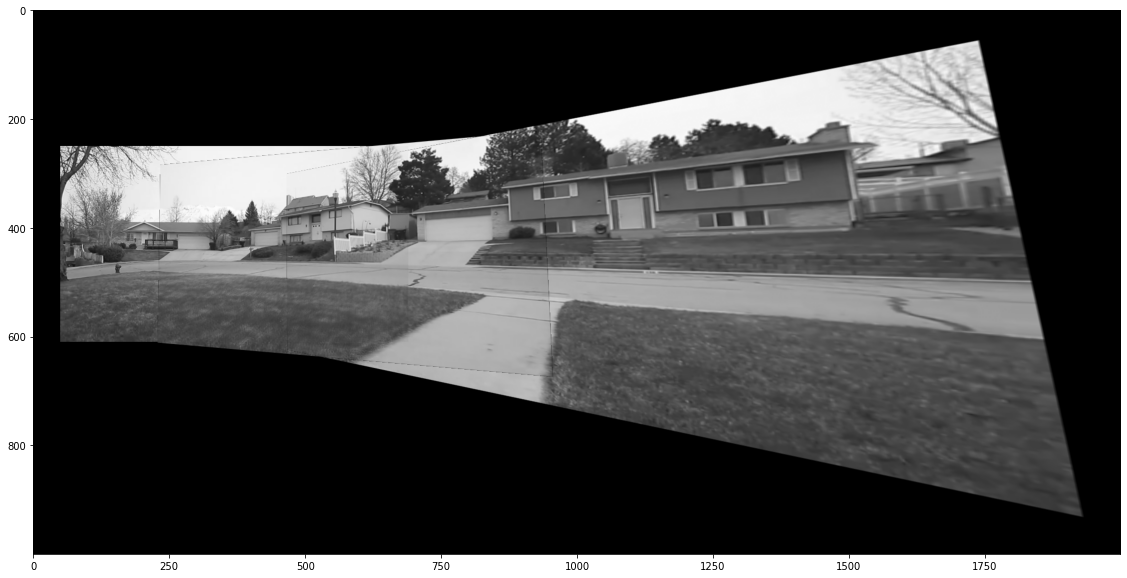

In [18]:
# Create a canvas
canvas = BWImage()
canvas.make_blank((1000, 2000))
img1_bw = BWImage(img1)
img2_bw = BWImage(img2)
img3_bw = BWImage(img3)
I = np.eye(3)
stitch(canvas, [img1_bw, img2_bw, img3_bw], H, 250, 50)
plt.figure(figsize = (60, 10))
plt.imshow(canvas.get_image())